In [1]:
# One-liner to start the debugger here.
#from IPython.core.debugger import Tracer; Tracer()()
#np.set_printoptions(threshold=np.inf)

import scipy.sparse as sp
import numpy as np
import time
import hashlib
import sys



In [2]:

def chunk_generator(fname, chunk_size=1000):
        data = []
        counter = 0

        with open(fname, 'r') as ifile:

            for line in ifile:
                if counter < chunk_size:
                    data.append([int(p) for p in line.split(" ")])
                    counter += 1
                if counter == chunk_size:
                    counter = 0
                    yield data
                    data = []
                    
            # process remaining elements
            if len(data) > 0:
                yield data

class ShingleFileParser:
    def __init__(self, fname):
        cindex = 0;
        for chunk in chunk_generator(fname, 40000):
            if cindex == 0 :
                self.D = chunk[0][0]
                self.W = chunk[1][0]
                self.X = sp.lil_matrix ((self.W,self.D))
                for i in range(3,len(chunk)):
                    self.add_to_matrix(chunk[i])
            else:
                for line in chunk :
                    self.add_to_matrix(line)
            cindex = cindex + 1
        
    def add_to_matrix(self,item):
            D_i = item[0] - 1
            W_i = item[1] - 1
            self.X[W_i,D_i] = 1
    
    def save_csc(self,filename):
        print("converting to csc (column-access optimized) sparse format ...")
        self.X = sp.csc_matrix(self.X)
        print("saving matrix with " + str(len(self.X.data)) + " elements")
        np.savez(filename,data = self.X.data ,indices=self.X.indices,
                 indptr = self.X.indptr, shape = self.X.shape)
        print ("content saved to " + filename)
            


In [3]:
start = time.time()
sf_parser =  ShingleFileParser('../data/docword.kos.txt')
end = time.time()
print("Parsing the file took " + str(end - start) + " seconds")
sf_parser.save_csc('../data/csc_kos');
del sf_parser

Parsing the file took 2.62999677658 seconds
converting to csc (column-access optimized) sparse format ...
saving matrix with 353160 elements
content saved to ../data/csc_kos


In [4]:
def load_sparse_csc(filename):
    loader = np.load(filename)
    return sp.csc_matrix((  loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])
X = load_sparse_csc('../data/csc_kos.npz')

In [5]:
def jaccard_similarity(A):
    # assumes that every document is a column-vector.
    # We will compute the "covariance" between every document to find how many elements are common.
    intersect = A.T.dot(A)
    D_len = np.zeros([1,A.shape[1]])
    for i in range(0,A.shape[1]):
        D_len[0,i] = A[:,i].size
    # a bit tricky .. create 2 "meshes" of the sizes : one vertical and one horizontal
    cardinality_sum = np.array(np.meshgrid(D_len, D_len))
    # add up the 2 mesh grids .. this adds up all the pairs of 2 documents
    cardinality_sum = np.sum(cardinality_sum,axis=0)
    # |union(a, b)| == |a| + |b| - |intersection(a, b)|
    union = cardinality_sum - intersect
    J= np.divide(intersect.todense(),union)
    return J

In [6]:
start = time.time()
# this contains duplicates (J[a,b] =J[b,a]). 
J = jaccard_similarity(X)
end = time.time()
print("Computing Jaccard similarity matrix took " + str(end - start) + " seconds")
# Also the diagonal would need to be ignored, since documents are similar to themselves
np.mean(J)

Computing Jaccard similarity matrix took 1.61752700806 seconds


0.03378473014650963

In [7]:
def find_next_prime(n):
    def find_prime_in_range(a, b):
            for p in range(a, b):
                for i in range(2, p):
                    if p % i == 0:
                        break
                else:
                     return p
            return None
    return find_prime_in_range(n, 2 * n)

In [8]:
def universal_row_hashes(h_sz,r_sz):
    N_prime = find_next_prime(h_sz)
    R = np.matrix(np.linspace(1,r_sz,r_sz,dtype=int))
    coef = np.random.randint(low=1,high=r_sz,size=[h_sz,2])
    A = np.matrix(coef[:,0]).T
    B = np.matrix(coef[:,1]).T
    H = (A * R + B )% N_prime % h_sz
    return H


In [17]:
import matplotlib.pyplot as plt
def show_hash_distribution(H):
    # check out the distribution of these random hash results
    hsh = np.asarray(H).flatten()
    plt.hist(np.asarray(Hsh).flatten())
    plt.show()

In [60]:
def minhash_signature(A,h_sz,show_hash_buckets=False):
    D = A.shape[1]
    W = A.shape[0]
    H = universal_row_hashes(h_sz,W)
    if show_hash_buckets:
        print("showing hash value distribution of words in the document using " 
                  + str(h_sz) + " distinct hash functions")
        show_hash_distribution(H)
    SGN = np.matrix(np.full([h_sz,D],sys.maxint))
    nz = A.nonzero()
    for i_nz in range(0,A.nnz):
        w_i = nz[0][i_nz]
        d_i = nz[1][i_nz]
        SGN[:,d_i] = np.minimum(H[:,w_i],SGN[:,d_i])
    return SGN

In [16]:
#def jaccard_similarity_between(c1,c2):
#    union = set()
#    intersect = 0
#    c1 = np.squeeze(np.asarray(c1))
#    c2 = np.squeeze(np.asarray(c2))
#    for i in range(0,len(c1)):
#        union.add(c1[i])
#        union.add(c2[i])
        #print(str(c1[i])+ " " + str(c2[i]))
#        if c1[i] == c2[i]:
#            from IPython.core.debugger import Tracer; Tracer()()
#            intersect = intersect + 1
#    return intersect/float(len(union))


def jaccard_similarity_between(c1,c2):
    # wherever the columns agree, zeros appear
    Y = c1 - c2
    # and intersection is the number of zeros
    intersect = len(c1) - np.nonzero(Y)[0].size
    return intersect/float(len(c1))

jaccard_similarity_between(SGN[:,11],SGN[:,5])


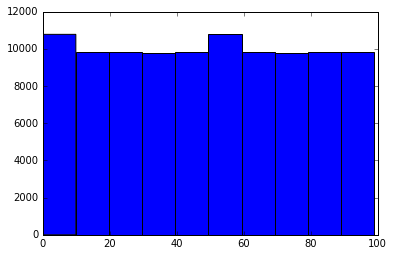

In [61]:
Hsh = universal_row_hashes(100,1000)
show_hash_distribution(Hsh)

showing hash value distribution of words in the document using 100 distinct hash functions


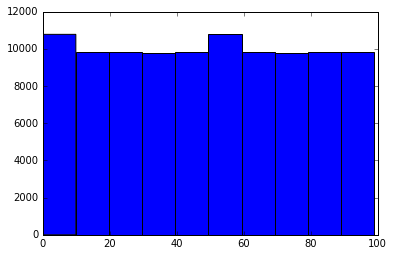

(100, 3430)

In [62]:
np.set_printoptions(threshold=100)
Sig = minhash_signature(X,100,show_hash_buckets=True)
Sig.shape

In [49]:
somematr = np.matrix([
    [2, 1, 2, 1],
    [2, 1, 4, 1],
    [1, 2, 1, 2]
])
#jaccard_similarity_between(somematr[:,1],somematr[:,3])
#np.minimum(somematr[:,0],somematr[:,2])


In [ ]:
# this is useless.. takes way too long. Use sklearn.metrics.pairwise.pairwise_distances
SGN=Sig
J_approx = np.zeros([SGN.shape[1],SGN.shape[1]])
ix = 0
for i in range(0,SGN.shape[1]):
    for j in range(i,SGN.shape[1]):
        sim = jaccard_similarity_between(SGN[:,i],SGN[:,j])
        J_approx[i,j] = sim
        J_approx[j,i] = sim
        if ix%10000 == 0:
            print("went through " + str(ix) + " values")
            print("got to row " + str(i) + " and col "+ str(j))
        ix = ix + 1
        
np.mean(J_approx)

In [50]:
np.set_printoptions(threshold=10)
import sklearn.metrics.pairwise as dist
J_SGN = 1-dist.pairwise_distances(Sig.T,metric='jaccard')

In [51]:
J_SGN[1,55]

0.068965517241379337

In [52]:
J[1,55]

0.038461538461538464

In [63]:
np.mean(J_SGN)

0.075261546146821567

In [64]:
np.mean(J)

0.03378473014650963